<a href="https://colab.research.google.com/github/AndrewRomitti/DeiT_Dementia_OASIS/blob/main/4Class_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#HuggingFace Data Efficient Image Transformer for Dementia Diagnosis

In [1]:
print("Starting Notebook")

Starting Notebook


In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
try:
  import datasets, evaluate, transformers
except:
  !pip install transformers datasets evaluate transformers[torch] > /dev/null 2>$1
  import datasets, evaluate, transformers
  print("Successfully installed libraries")

In [5]:
from google.colab import files
files.upload()

Saving kaggle (7).json to kaggle (7).json


{'kaggle (7).json': b'{"username":"andrewromitti1","key":"157025cf2ff7a56ce7dcefe64752dbdb"}'}

In [6]:
!pip install -q kaggle > /dev/null 2>&1

In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [8]:
!chmod 600 /root/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d ninadaithal/imagesoasis

100% 1.23G/1.23G [00:44<00:00, 39.5MB/s]
100% 1.23G/1.23G [00:44<00:00, 30.0MB/s]


In [10]:
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images > /dev/null 2>&1

In [11]:
!unzip /content/imagesoasis.zip > /dev/null 2>&1
print("Unzipped")

Unzipped


In [12]:
import os

PATH = r"/content/Data/"

for dir in os.listdir(PATH):
  print(dir)

Non Demented
Very mild Dementia
Moderate Dementia
Mild Dementia


Text(0.5, 0, 'Number of Images')

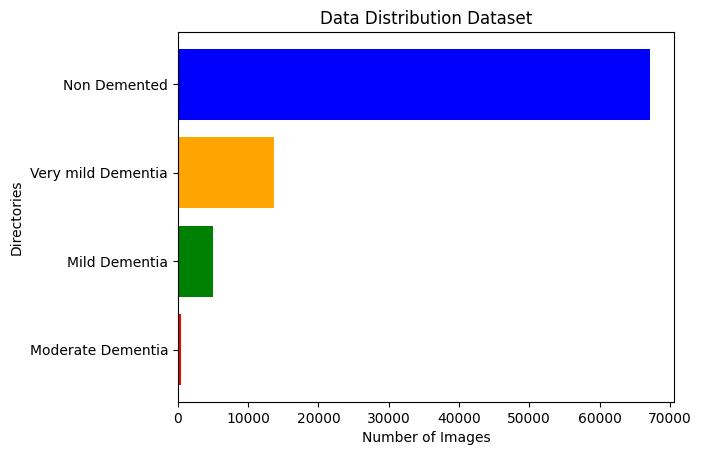

In [13]:
import os
import matplotlib.pyplot as plt


#Data Distribution for Training
PATH = r"/content/Data"

x_axis = ["Non Demented", "Very mild Dementia", "Mild Dementia", "Moderate Dementia"]
x_axis = x_axis[::-1]
colors = ["red", "green","orange","blue"]
y_axis = []

for dir in x_axis:
  target_dir = PATH + "/" + dir
  files = os.listdir(target_dir)
  count = len(files)
  y_axis.append(count)

plt.barh(x_axis, y_axis,color=colors)
plt.title("Data Distribution Dataset")
plt.ylabel("Directories")
plt.xlabel("Number of Images")

In [ ]:
os.listdir(PATH)

['Very mild Dementia', 'Mild Dementia', 'Non Demented', 'Moderate Dementia']

In [ ]:
####CODE FOR ALTERNATIVE DATASET####

#import shutil

#PATH = PATH

#for dir in os.listdir(PATH):
#  for fiel in os.listdir(PATH+"/"+dir+"/"):
#    print(fiel)
#    shutil.move(PATH+"/"+dir+"/"+fiel, r"/content/drive/MyDrive/MRI_Project/SyntheticDs2/train"+"/"+dir+"/") > /dev/null 2>&1

In [14]:
import numpy as np

y_axis = np.array(y_axis)
weights = 1./y_axis

In [15]:
import datasets

#If training GAN
ds = datasets.load_dataset("imagefolder", data_dir=r"/content/Data")
ds = ds["train"].train_test_split(test_size=0.2)

#If training Real Data
#ds = datasets.load_dataset("imagefolder", data_dir=r'/content/Alzheimer_s Dataset')
ds_train = ds["train"].shuffle(seed=1)
ds_test = ds["test"]

Resolving data files:   0%|          | 0/86437 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [16]:
checkpoint = "facebook/deit-base-distilled-patch16-224"

image_processor = transformers.AutoImageProcessor.from_pretrained(checkpoint, return_tensors="pt")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [17]:
len(ds_train)

69149

In [18]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torchvision.transforms as T
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.transforms.autoaugment import AutoAugmentPolicy

train_tfs = Compose([
      T.ElasticTransform(),
      Resize(size=(224,224)),
      ToTensor(),
      Normalize(mean=[0.5],
                std=[0.5])
    ]
    )

test_tfs = Compose(
    [
      Resize(size=(224,224)),
      ToTensor(),
      Normalize(mean=[0.5],
                std=[0.5])
    ]
)

def train_transforms(example):
  example["pixel_values"] = [train_tfs(image.convert("RGB")) for image in example["image"]]
  del example["image"]
  return example

def test_transforms(example):
  example["pixel_values"] = [test_tfs(image.convert("RGB")) for image in example["image"]]
  del example["image"]
  return example

ds["train"] = ds["train"].with_transform(train_transforms)
ds["test"] = ds["test"].with_transform(test_transforms)

In [19]:
import evaluate
import numpy as np

f1 = evaluate.load("f1")
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": np.mean(predictions == labels)}

In [20]:
labels = ds["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [21]:
data_collator = transformers.DefaultDataCollator(return_tensors="pt")

In [22]:
model = transformers.DeiTForImageClassification.from_pretrained(checkpoint,
                               num_labels=len(labels),
                               id2label=id2label,
                               label2id=label2id,
                               ignore_mismatched_sizes=True,
                               )

model.config = transformers.DeiTConfig(hidden_dropout_prob=0.1, attention_probs_dropout_prob = 0.1)

model = model.to("cuda")

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/349M [00:00<?, ?B/s]

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
temp = y_axis[2]
temp_2 = y_axis[3]

y_axis[3] = y_axis[0]
y_axis[2] = temp_2
y_axis[0] = y_axis[1]
y_axis[1] = temp

y_axis

array([ 5002, 13725, 67222,   488])

In [24]:
def compute_class_weights(class_counts):
  updated_counts = []
  total = sum(y_axis)
  for count in class_counts:
    updated_counts.append(1-(count/total))

  return np.array(updated_counts)

class_weights = torch.tensor(compute_class_weights(y_axis),dtype=torch.float)

In [25]:
import torch.nn as nn

class WeightedTransformer(transformers.Trainer):

  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

  def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=class_weights.to("cuda" if torch.cuda.is_available() else "cpu"))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [26]:
args = transformers.TrainingArguments(
    output_dir="alzheimer_model_aug_deit60",
    overwrite_output_dir=True,
    remove_unused_columns=False,


    weight_decay=0.01,
    warmup_steps=6,

    logging_steps=1800//20,
    num_train_epochs=100,
    evaluation_strategy="epoch",
    per_device_eval_batch_size=32,
    per_device_train_batch_size=32,
    metric_for_best_model="accuracy",
    gradient_accumulation_steps=4,
    eval_accumulation_steps=3,


    load_best_model_at_end=True,
    greater_is_better=True,
    save_strategy="epoch",
    seed=1234,


)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
from transformers.optimization import Adafactor, AdafactorSchedule

optimizer = Adafactor(model.parameters(), scale_parameter=True, relative_step=True, warmup_init=True, lr=None)
lr_scheduler = AdafactorSchedule(optimizer)

In [29]:
trainer = WeightedTransformer(
    model=model,
    args=args,
    data_collator=data_collator,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics, #If numbers are dissapointing delete this line of code
)

In [30]:
trainer = transformers.Trainer(
    model=model,
    args=args,
    data_collator=data_collator,
    train_dataset=ds["train"],
    eval_dataset = ds["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics
)

In [ ]:
#!pip install git+https://github.com/huggingface/accelerate
#!pip install --upgrade transformers

In [31]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
0,0.025200,0.023157,0.991381


KeyboardInterrupt: 